# Part 4: Introduction to Machine Learning

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Loading the Data

<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/pythonseries/titanic_sinking.png" width="20%" align="right"/>

In this tutorial, we're going to be using the [Titanic dataset](https://www.kaggle.com/c/titanic/data) which is publicly available on Kaggle. Our goal will be to build a machine learning model that predicts which passengers survived the Titanic. 

The "label" in our dataset is `Survival` - it's what we want to predict in our model. When we train our model, we want to be able to find patterns in our features that can be used to predict whether a passenger survived.

Here's a data dictionary that maps out what each column name represents:

|Variable|Definition|Key|
|-------|----------|-----|
|Survival|whether the passenger survived (our label)|0=No,1=Yes|
|Pclass|ticket class|1=1st class, 2=2nd class, 3=3rd class|
|Sex|sex of the passenger| |
|Age|age of the passenger (in years)| |
|SibSp|number of siblings/spouses aboard the Titanic| |
|Parch|number of parents/children aboard the Titanic| |
|Ticket|ticket number| |
|Fare|cost of ticket| |
|Cabin|cabin number| |
|Embarked|port of embarkation|C=Cherbourg, Q=Queenstown, S=Southampton|

Let's load in our Titanic dataset from the cloud and take a peek at the type of data that we're working with.

In [13]:
titanic_data = pd.read_csv("https://s3.us-east-2.amazonaws.com/explore.datasets/rbi/titanic_train.csv")
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


How many columns and rows are in our dataset?

In [14]:
titanic_data.shape

(891, 12)

What are the datatypes of the columns?

In [15]:
titanic_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### Assessing Missing Values

Do we have any missing values in our dataset? 

In [18]:
titanic_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

It appears that `Age`, `Cabin`, and `Embarked` are the only columns that have missing values. The `Cabin` column has a significant amount of missing values (77%) while `Age` has fewer missing values (20%). 

### What proportion of passengers survived?

Of the passengers in this dataset, what proportion survived the shipwreck?

In [30]:
titanic_data['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Only 38% of passengers survived the shipwreck.

### What was the age distribution?

Mean age was 29.7


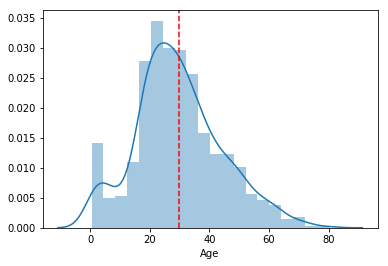

In [29]:
mean_age = titanic_data['Age'].mean()
print(f"Mean age was {round(mean_age,2)}")

sns.distplot(titanic_data['Age'].dropna())
plt.axvline(mean_age, color='red', linestyle='--')

The average age of a passenger on board the Titanic was 29.7 years old. The mean is represented as a red dotted line in the plot above.

### What was the male-female ratio? 

What proportion of passengers were male vs. female?

In [31]:
titanic_data['Sex'].value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

The male-female ratio was ~65:35. Passengers were predominantly male.

### What was the distribution in ticket prices?

Was there a large disparity between the most and least expensive tickets?

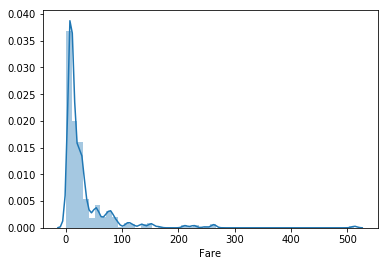

In [32]:
sns.distplot(titanic_data['Fare'])

In [35]:
min_fare = titanic_data['Fare'].min()
max_fare = titanic_data['Fare'].max()
mean_fare = titanic_data['Fare'].mean()

print(f"The lowest fare was {min_fare}.")
print(f"The highest fare was {round(max_fare,2)}.")
print(f"The mean fare was {round(mean_fare,2)}.")

The lowest fare was 0.0.
The highest fare was 512.33.
The mean fare was 32.2.


There is a large disparity in fare price, but it appears that a large proportion of tickets cost under 50 dollars.

### What's the distribution in passenger class?

`Pclass` is a column that represents the class of a ticket. Did the passenger stay in first class, second class or third class? Which class contained the most passengers?

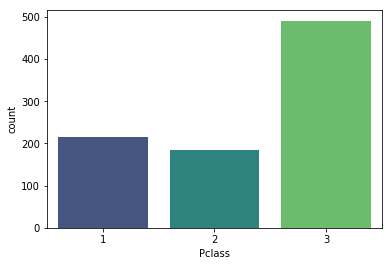

In [37]:
sns.countplot(titanic_data['Pclass'], palette='viridis')

In [38]:
titanic_data['Pclass'].value_counts(normalize=True)

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

More than half of the passengers were in third class, which may explain why a large proportion of tickets cost under 50 dollars. We can confirm this by grouping by `Pclass` and seeing what the average fare was for each class.

In [40]:
titanic_data.groupby('Pclass')['Fare'].mean().reset_index()

,Pclass,Fare
0,1,84.154687
1,2,20.662183
2,3,13.675550


The output above confirms that third class tickets cost the least (mean of \\$13) while the first class tickets cost the most (mean of \\$84).

### Data Pre-processing

Before we start training our machine learning (ML) model, we need to do some data pre-processing to get our data in the appropriate format. 

Which features do we want to include in our model? 

In [41]:
titanic_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

To keep our model simple, let's use 6 features for our initial model:

- `Pclass`
- `Sex`
- `Age`
- `SibSp`
- `Parch`
- `Fare`

In [43]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

By tradition, the data containing the features is called `X` (upper case) and the data containing the "label" is `y` (lower case). Let's create new dataframes that represent our `X` and `y` data.

In [47]:
X = titanic_data[features]
y = titanic_data[['Survived']]

Most ML models aren't able to handle missing values, so we'll need to deal with these now. We're going to be including `Age` as a feature of our model, which contains missing values. There are several things that we can do to handle this. Some approaches involve complex imputation. For the purpose of this tutorial, we're going to handle this missingness problem by simply dropping all rows where `Age` is missing.

In [48]:
print(f"Shape before dropping missing values: {X.shape}")

X = X.dropna()

print(f"Shape after dropping missing values: {X.shape}")

Shape before dropping missing values: (891, 6)
Shape after dropping missing values: (714, 6)


By dropping missing values, we went from 891 to 714 rows.

Another thing that we'll need to update is our `Sex` column. ML models typically don't accept categorical variables containing strings. `Sex` is currently represented by "male" and "female". We'll need to convert these values to 0 and 1 in order for our model to work properly.

In [50]:
X['Sex'] = X['Sex'].map({'female': 0, 'male': 1})

Great! Our `X` dataset is now ready for model training. 

### Choosing a Model

When building a binary classification model, there are a wide selection of machine learning models to choose from:

- Random Forest Classification
- Logistic Regression
- Linear Discriminant Analysis
- Support Vector Machines (SVM)
- Gaussian Naive Bayes
- k-Nearest Neighbours

We’ll test out the [Random Forest Classifier (RFC)](https://towardsdatascience.com/understanding-random-forest-58381e0602d2) for this dataset. RFC is an ensemble learning technique that works by creating a "forest" of decision trees. Each tree evaluates the data for a given passenger and outputs a 0 or 1. Random Forest looks at the output of all trees and gives the majority vote as its result. Let’s say we have a forest with 3 trees and 2 of them predict the passenger will be survive. The majority vote is that the passenger will survive.

We’re choosing Random Forest because:

- it is robust to outliers
- it is able to handle unbalanced datasets
- it measures feature importance

We’ll import RFC from [scikit-learn](https://scikit-learn.org) which is a very comprehensive Python library for data mining and data analysis.

In [9]:
from sklearn.ensemble import RandomForestClassifier

We can inspect the default parameters for RandomForestClassifier by creating an instance of the class and applying `get_params()`:

In [10]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

You can keep the default values for most of these parameters. But there are a few that can be modified prior to training the model that can impact model performance. These are called hyperparameters. Some RFC hyperparameters include:

- `n_estimators`: number of trees in the forest
- `max_depth`: maximum number of levels in each decision tree
- `max_features`: maximum number of features considered for splitting a node
- `min_samples_split`: number of data points placed in a node before the node is split

These are external configurations that can’t be learned from training the model. To select the optimal values of a hyperparameter, we’ll need to use a technique called hyperparameter tuning.